In [125]:
import random

from torch import nn
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, AutoModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from batch_doc_pipeline import *

random.seed(42)
reshuffle_docs = False

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

batch_size = 10 # documents
learning_rate = 2e-4
n_epochs = 20

task_list = ['Quantity','MeasuredProperty','MeasuredEntity','Qualifier']
task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4}

model_name = 'allenai/biomed_roberta_base'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_size_reduce = 1 # multiplier for making small datasets



In [126]:
########## Tokenizer ###########

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

In [127]:
class OurBERTModel(nn.Module):
    def __init__(self):
        super(OurBERTModel, self).__init__()
        self.mod = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, 2) # for measured entity

    def forward(self, text, att_mask):
        b, num_tokens = text.shape
        token_type = torch.zeros((b, num_tokens), dtype=torch.long).to(device)
        outputs = self.mod(text, attention_mask=att_mask, token_type_ids=token_type)
        return self.classifier(self.drop(outputs['last_hidden_state']))

model = OurBERTModel()

print(sum(p.numel() for p in model.parameters()),"parameters!")
model = model.to(device)
print("Detected", torch.cuda.device_count(), "GPUs!")

Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


124647170 parameters!
Detected 1 GPUs!


In [128]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [129]:
train_annot, dev_annot, test_annot, train_txt, dev_txt, test_txt = read_data(reshuffle_docs = reshuffle_docs)

train_docIds = list(set(train_annot['docId']))
dev_docIds = list(set(dev_annot['docId']))
test_docIds = list(set(test_annot['docId']))

In [132]:
## todo write a func that preprocess the annotation dataframe to look like the spreadsheet
# (michelle, but sam did it because he was super impatient and he's really sorry)

combo_docIds = train_docIds + dev_docIds + test_docIds
combo_annot = pd.concat([train_annot,dev_annot,test_annot],ignore_index=True)

def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']

        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':
                # ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                # link = list(otherDict.values())[0]

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [max(spanEnds),min(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.sample(7)


,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S0006322312001096-1248_T21-1,S0006322312001096-1248,T21-1,MeasuredEntity,"[594, 596]",HasQuantity,T11-1,"[590, 593]","[596, 590]",NaN,NaN,NaN
S0378383913001567-6892_T2-10,S0378383913001567-6892,T2-10,MeasuredProperty,"[450, 463]",HasQuantity,T1-10,"[469, 472]","[472, 450]",NaN,NaN,NaN
S0032063313003218-7156_T1-2,S0032063313003218-7156,T1-2,Quantity,"[176, 179]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsApproximate']}
S2213671113001306-1520_T5-3,S2213671113001306-1520,T5-3,Qualifier,"[479, 502]",Qualifies,T2-3,"[466, 478]","[502, 466]",NaN,NaN,NaN
S0927024813002420-1032_T4-4,S0927024813002420-1032,T4-4,MeasuredEntity,"[539, 568]",HasProperty,T3-4,"[589, 592]","[592, 539]",NaN,NaN,NaN
S0006322312001096-1177_T1-10,S0006322312001096-1177,T1-10,Quantity,"[574, 586]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsRange']}
S0012821X12004384-1148_T2-3,S0012821X12004384-1148,T2-3,MeasuredEntity,"[880, 931]",HasQuantity,T11-3,"[937, 953]","[953, 880]",NaN,NaN,NaN


In [ ]:

currentdir = os.getcwd() # ~/MeasEval/baselines
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')

combo_annot_processed.head()

In [9]:
### insert special tokens for subspans (Sam)
# will make docs longer

def tokenize_and_align_labels(docs_or_sents, txt, annotation, tokenizer, task_list):

    toks_with_labels = []

    for doc in docs_or_sents:
        # print(doc)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        # print(encoded_txt)

        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        doc_annot = annotation.loc[annotation['docId'] == doc]
        # print(doc_annot)

        annot_spans = doc_annot[['annotType','startOffset','endOffset']]


        special_ids = tokenizer.all_special_ids
        # print(label_ids.shape)

        for task in task_list:
            label_ids = np.full(len(encoded_tokens),0)
            task_spans = np.array(annot_spans.loc[annot_spans['annotType']==task][['startOffset','endOffset']])
            

            # Make a Func
            for token_idx, token in enumerate(encoded_tokens):
                # decoded_token = tokenizer.decode(token)
                # print(f"token index: {token_idx}")
                # print(f"decoded token: {decoded_token}")

                if token in special_ids:
                    label_ids[token_idx] = 0
                    # print('special token')

                else:
                    token_start_char = encoded_txt.token_to_chars(token_idx).start
                    token_end_char = encoded_txt.token_to_chars(token_idx).end
                    # print(f"token span: {[token_start_char,token_end_char]}")
                    for start, end in task_spans:
                        if start <= token_start_char <= end:
                            label_ids[token_idx] = task_map[task]
                            # print(f'{type} entity found spanning {[start,end]}')
                            break
                        else:
                            label_ids[token_idx] = 0
                            # print("no entity found")
                # end func

            encoded_txt[str(task+'_label')] = label_ids
           
        
        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = list(label_ids)
        
        toks_with_labels.append(encoded_txt)
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [10]:
################# TOKENIZE #################
train_docIds = random.sample(train_docIds, int(len(train_docIds)*data_size_reduce))

quant_train_ds = tokenize_and_align_labels(
    docs_or_sents=train_docIds,
    txt=train_txt,
    annotation=train_annot,
    tokenizer=tokenizer,
    task_list=task_list)
num_train_docs = quant_train_ds.shape[0]

dev_docIds = random.sample(dev_docIds, int(len(dev_docIds)*data_size_reduce))

quant_dev_ds = tokenize_and_align_labels(
    docs_or_sents=dev_docIds,
    txt=dev_txt,
    annotation=dev_annot,
    tokenizer=tokenizer,
    task_list=task_list)
num_dev_docs = quant_dev_ds.shape[0]

test_docIds = test_docIds

quant_test_ds = tokenize_and_align_labels(
    docs_or_sents=test_docIds,
    txt=test_txt,
    annotation=test_annot,
    tokenizer=tokenizer,
    task_list=task_list)
num_test_docs = quant_test_ds.shape[0]


In [89]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

toks = list(quant_dev_ds.loc[quant_dev_ds['doc_or_sent_id']=='S0022000014000026-18167']['input_ids'])

print(toks[0])

tokenizer.decode(toks[0])

[0, 1620, 5, 6427, 9, 84, 2225, 6, 52, 122, 7118, 7, 61, 5239, 5, 3611, 9, 84, 5574, 9, 5, 39189, 2118, 2744, 17194, 6, 61, 33, 57, 2327, 8, 13031, 624, 84, 19039, 7208, 8, 4776, 9280, 2368, 6, 972, 84, 1521, 1175, 4, 9870, 6, 52, 40, 2268, 10, 346, 9, 801, 5139, 8, 499, 557, 19922, 4, 1541, 43733, 40, 1407, 5, 25212, 8608, 3147, 11, 7162, 132, 4, 134, 4, 406, 4, 21438, 42895, 4850, 35, 286, 10, 10686, 5574, 6, 5, 746, 346, 9, 14213, 16, 384, 1640, 35760, 18857, 43, 228, 37908, 4, 152, 64, 28, 450, 30, 21981, 14, 5, 13879, 9, 5, 11543, 14213, 16, 17349, 5, 25, 8307, 3320, 13510, 346, 9, 14213, 6, 187, 5, 384, 1640, 282, 43, 2405, 6411, 9, 10, 37908, 33, 10, 5891, 346, 9, 14213, 349, 131, 634, 28662, 4836, 7, 5731, 11543, 14213, 6, 5, 2305, 13879, 8191, 3905, 646, 3818, 8174, 6892, 705, 11416, 6, 42, 346, 9, 14213, 16, 10, 3724, 9, 384, 1640, 462, 18857, 43, 31, 19329, 4, 166, 43132, 14, 11, 754, 42, 13879, 16, 25, 8307, 3320, 1242, 3435, 19329, 6, 3867, 65, 16, 2882, 7, 9802, 97, 21453

'<s>As the conclusion of our paper, we now assess to which extent the properties of our implementation of the FATAL+ algorithm, which have been expressed and verified within our modeling framework and tested experimentally, meet our design goals. Furthermore, we will discuss a number of potential improvements and future research avenues. Our exposition will follow the optimization criteria listed in Section 2.1.7.•Area consumption: For a suitable implementation, the total number of gates is O(nlogn) per node. This can be seen by observing that the complexity of the threshold gates is dominating the asymptotic number of gates, since the O(n) remaining components of a node have a constant number of gates each; using sorting networks to implement threshold gates, the stated complexity bound follows [48]. Trivially, this number of gates is a factor of O(logn) from optimal. We conjecture that in fact this complexity is asymptotically optimal, unless one is willing to sacrifice other desirab

In [48]:
quant_train_ds.loc[3]

MeasuredEntity_label      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
MeasuredProperty_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Qualifier_label           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Quantity_label            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
attention_mask            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
doc_or_sent_id                                        S0167577X14001256-389
input_ids                 [0, 3762, 12, 23944, 15229, 11729, 9, 6945, 6,...
labels                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

In [49]:
quant_train_ds.loc[3]['MeasuredEntity_label']

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
quant_train_ds.loc[3]['Quantity_label'] + quant_train_ds.loc[3]['MeasuredEntity_label']

array([0, 0, 0, 1, 1, 1, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist()).to(device)
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist()).to(device)
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)
        # print(labels.shape)
        # doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            # 'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [40]:
################# batchify ####################
batched_quant_train_ds = batchify(quant_train_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_quant_dev_ds = batchify(quant_dev_ds[['attention_mask','input_ids','Quantity_label']], batch_size, device)
batched_quant_test_ds = batchify(quant_test_ds[['attention_mask','input_ids','Quantity_label']], batch_size, device)


In [ ]:
def train_epoch(ds):

    model.train()
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        output = model(input_ids, attention_mask)
        logits = output.permute(0,2,1)
        
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        predictions = torch.argmax(logits, dim=1)

        progress_bar.update(1)
            
    return loss



def eval_epoch(ds):
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            output = model(input_ids, attention_mask)
            logits = output.permute(0,2,1)
            
            loss = criterion(logits, labels)
            
            predictions = torch.argmax(logits, dim=1)
            
            y_pred = []
            y_true = []
            for i in range(predictions.shape[0]):
                last_tok = attention_mask[i].sum()-1
                y_pred.append(predictions[i][:last_tok].cpu().numpy())
                y_true.append(labels[i][:last_tok].cpu().numpy())

            y_true = np.concatenate(y_true).ravel()
            y_pred = np.concatenate(y_pred).ravel()

    return y_true, y_pred, input_ids, attention_mask, loss

In [ ]:

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_quant_train_ds)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

run_report = {  'epoch':[],
                'train_loss':[],
                'train_eval_loss':[],
                'dev_eval_loss':[],
                'train_accuracy':[],
                'train_precision':[],
                'train_recall':[],
                'train_f1':[],
                'train_support':[],
                'dev_accuracy':[],
                'dev_precision':[],
                'dev_recall':[],
                'dev_f1':[],
                'dev_support':[]}

for epoch in range(num_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"\n============ Begin Epoch {epoch+1} ============")

    loss = train_batch(batched_quant_train_ds)
    run_report['train_loss'].append(loss.detach().cpu().numpy())
    
    y_true_train, y_pred_train, loss = eval_batch(batched_quant_train_ds)
    print('Training Set Classification Report:')
    train_report = classification_report(y_true_train, y_pred_train,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(train_report[type])
    run_report['train_eval_loss'].append(loss.cpu().numpy())
    run_report['train_accuracy'].append(train_report['accuracy'])
    run_report['train_precision'].append(train_report[type]['precision'])
    run_report['train_recall'].append(train_report[type]['recall'])
    run_report['train_f1'].append(train_report[type]['f1-score'])
    run_report['train_support'].append(train_report[type]['support'])

    y_true_dev, y_pred_dev, loss = eval_batch(batched_quant_dev_ds)
    print('\nDev Set Classification Report:')
    dev_report = classification_report(y_true_dev, y_pred_dev,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(dev_report[type])
    run_report['dev_eval_loss'].append(loss.cpu().numpy())
    run_report['dev_accuracy'].append(dev_report['accuracy'])
    run_report['dev_precision'].append(dev_report[type]['precision'])
    run_report['dev_recall'].append(dev_report[type]['recall'])
    run_report['dev_f1'].append(dev_report[type]['f1-score'])
    run_report['dev_support'].append(dev_report[type]['support'])

run_report = pd.DataFrame.from_dict(run_report)

  0%|          | 0/600 [00:00<?, ?it/s]


============ Begin Epoch 1 ============
Training Set Classification Report:
{'precision': 0.9495798319327731, 'recall': 0.3138888888888889, 'f1-score': 0.4718162839248434, 'support': 360}

Dev Set Classification Report:
{'precision': 0.8636363636363636, 'recall': 0.2389937106918239, 'f1-score': 0.37438423645320196, 'support': 159}

============ Begin Epoch 2 ============
Training Set Classification Report:
{'precision': 0.8899082568807339, 'recall': 0.8083333333333333, 'f1-score': 0.8471615720524018, 'support': 360}

Dev Set Classification Report:
{'precision': 0.7417218543046358, 'recall': 0.7044025157232704, 'f1-score': 0.7225806451612902, 'support': 159}

============ Begin Epoch 3 ============
Training Set Classification Report:
{'precision': 0.8463541666666666, 'recall': 0.9027777777777778, 'f1-score': 0.8736559139784946, 'support': 360}

Dev Set Classification Report:
{'precision': 0.6161137440758294, 'recall': 0.8176100628930818, 'f1-score': 0.7027027027027027, 'support': 159}


In [ ]:
run_report


,epoch,train_loss,train_eval_loss,dev_eval_loss,train_accuracy,train_precision,train_recall,train_f1,train_support,dev_accuracy,dev_precision,dev_recall,dev_f1,dev_support
0,0,0.1372025,0.119938746,0.09856832,0.879981,0.949580,0.313889,0.471816,360,0.856982,0.863636,0.238994,0.374384,159
1,1,0.07115574,0.060669303,0.07146564,0.950190,0.889908,0.808333,0.847162,360,0.903153,0.741722,0.704403,0.722581,159
2,2,0.10287207,0.050270807,0.09087617,0.955408,0.846354,0.902778,0.873656,360,0.876126,0.616114,0.817610,0.702703,159
3,3,0.039818745,0.02997541,0.09739403,0.973909,0.939481,0.905556,0.922207,360,0.864865,0.592417,0.786164,0.675676,159
4,4,0.029263053,0.02278673,0.10713688,0.981025,0.944444,0.944444,0.944444,360,0.869369,0.604878,0.779874,0.681319,159
5,5,0.028614739,0.024706526,0.18394034,0.977704,0.906494,0.969444,0.936913,360,0.858108,0.562264,0.937107,0.702830,159
6,6,0.026034331,0.012771824,0.11479724,0.985769,0.974138,0.941667,0.957627,360,0.904279,0.696809,0.823899,0.755043,159
7,7,0.016817298,0.009311733,0.10993675,0.991935,0.980392,0.972222,0.976290,360,0.904279,0.710227,0.786164,0.746269,159
8,8,0.01368284,0.007144925,0.12746535,0.994782,0.991549,0.977778,0.984615,360,0.900901,0.689840,0.811321,0.745665,159
9,9,0.0074655153,0.0046385825,0.13548242,0.996205,0.991620,0.986111,0.988858,360,0.905405,0.709497,0.798742,0.751479,159


In [ ]:
##### todo: save reports and results to files

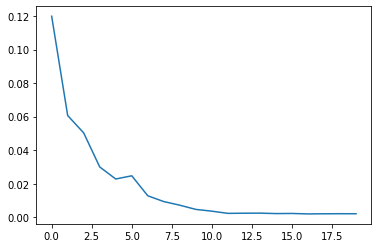

In [ ]:
########################## training loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['train_eval_loss'])
plt.plot(x,y)
plt.show()

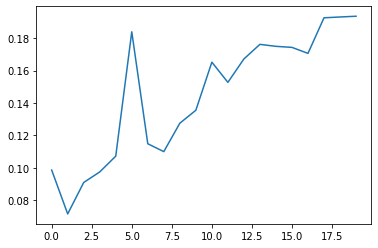

In [ ]:
########################## eval loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['dev_eval_loss'])
plt.plot(x,y)
plt.show()

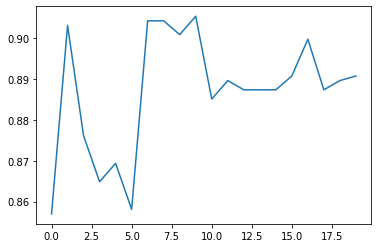

In [ ]:
import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['dev_accuracy'])
plt.plot(x,y)
plt.show()

In [ ]:
###################### single batch training debugging ######################
# batch = batched_quant_train_ds[0]

# model.train()

# labels = batch['labels']
# # print(labels)
# input_ids = batch['input_ids']
# # print(input_ids)
# attention_mask = batch['attention_mask']
# # print(attention_mask)

# outputs = model(input_ids, attention_mask)
# logits = outputs

# train_loss = criterion(logits.permute(0,2,1), labels)

# train_loss.backward()
# optimizer.step()
# lr_scheduler.step()
# optimizer.zero_grad()

In [ ]:
###################### single batch prediction debugging ######################

# batch = batched_quant_dev_ds[0]

# model.eval()

# with torch.no_grad():
#     labels = batch['labels']
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']

#     output = model(input_ids, attention_mask)
#     logits = output.permute(0,2,1)

#     loss = criterion(logits, labels)
#     logger['eval_losses'].append(loss.item())

#     predictions = torch.argmax(logits, dim=1)
#     accuracy = acc_f(labels,predictions).item()
#     print(accuracy)
#     f1 = f1_f(labels,predictions).item()
#     print(f1)

#     # labels = labels[0].cpu().numpy()
#     # predictions = predictions[0].cpu().numpy()

#     # confusion_matrix(labels,predictions[0].cpu().numpy())
# print(predictions.shape)
# print(attention_mask.shape)
# print(labels.shape)
# print(torch.sum(attention_mask[0]))
# # np.nonzero(attention_mask[0])[-1].item()
# last = attention_mask[0].sum()
# y_pred = []
# y_true = []
# for i in range(predictions.shape[0]):
#     last_tok = attention_mask[i].sum()-1
#     y_pred.append(predictions[i][:last_tok].cpu().numpy())
#     y_true.append(labels[i][:last_tok].cpu().numpy())

# y_true = np.concatenate(y_true).ravel()
# y_pred = np.concatenate(y_pred).ravel()

# y_true.shape
# y_pred.shape
# classification_report(y_true, y_pred, output_dict=True)['1']